In [1]:
from models import AnnLassoRegression, AnnLassoClassification, LinearModel
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import multiprocessing
import warnings
warnings.filterwarnings("ignore")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

In [56]:
X = np.random.normal(size = (5000, 50))
y, s = utils.generate_nonlinear_data(X, 6)

model = AnnLassoRegression(penalty = 1, p2=20)
model.fit(X,y, True, True)

0    14.605107
dtype: float64


'\nmodel = AnnLassoRegression(penalty = 1, p2=20)\nmodel.fit(X,y, True, True)\n'

In [52]:
model.important_features

(2, [18, 41])

In [53]:
s

array([10, 40, 41, 27, 36, 18])

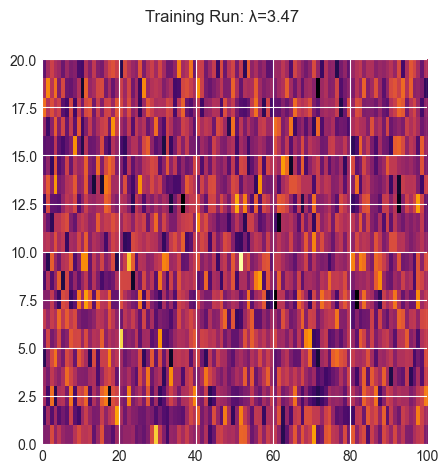

In [25]:
model.layer1_evolution()

In [54]:
model.layer1_simplified.weight.data

tensor([[-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [ 7.6614, -0.0000],
        [-0.0000, -0.0000],
        [-8.3307,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -8.0568],
        [-0.0000, -0.0000],
        [-0.0000,  8.1026],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000]])

In [3]:
def load_and_concatenate_data(lmbd_suffix, col_names):
    models = {}
    sample_sizes = ['10', '40', '70', '100', '130', '160']
    base_path = "data/linear/n{}/PESR{}.csv"
    
    for col_name in col_names:
        frames = [pd.read_csv(base_path.format(n, lmbd_suffix))[col_name] for n in sample_sizes]
        concatenated = pd.concat(frames, axis=1)
        concatenated.columns = sample_sizes
        models[col_name] = concatenated
    
    return models

column_names = ["linear old", "neural old", "linear new", "neural new"]
models_08 = load_and_concatenate_data("-0.8lambda", column_names)
models = load_and_concatenate_data("", column_names)
models_12 = load_and_concatenate_data("-1.2lambda", column_names)

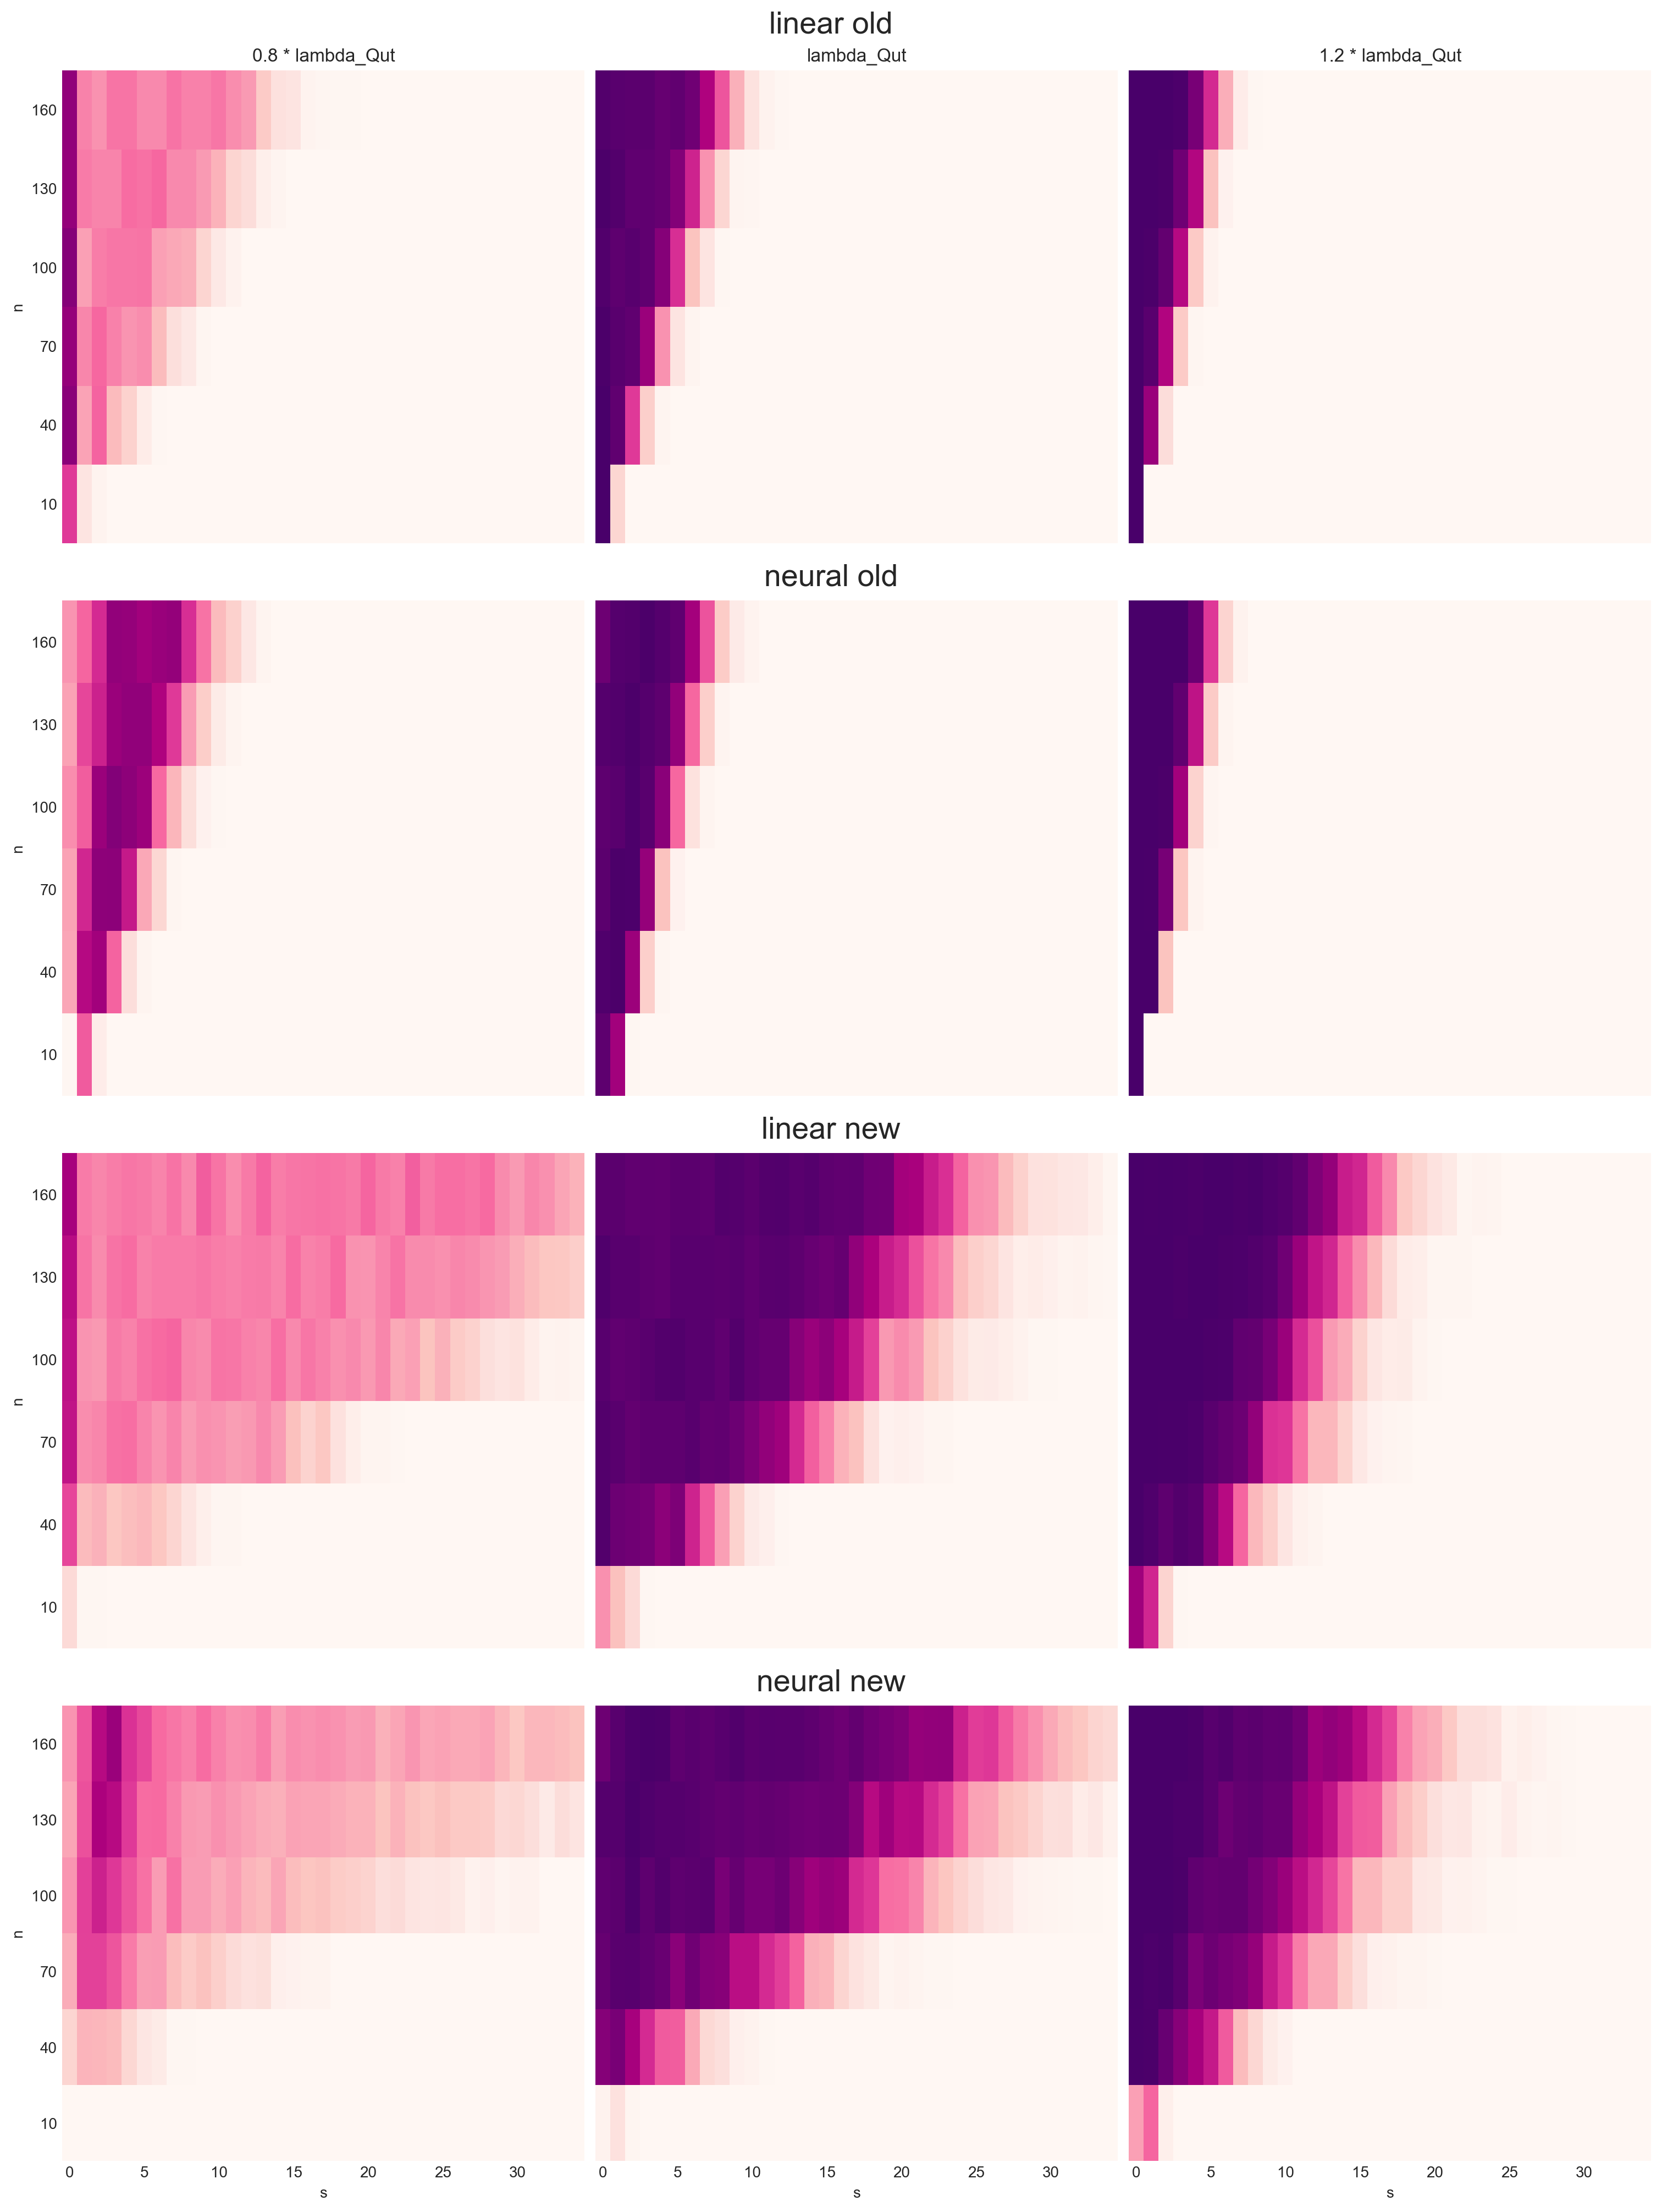

In [5]:
column_titles = ['0.8 * lambda_Qut', 'lambda_Qut', '1.2 * lambda_Qut']
row_titles = list(models.keys())
y_labels = list(models['linear old'].columns)
x_labels = range(0, models['linear old'].shape[0], 5)


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), constrained_layout=True, dpi=200)

for ax in axes:
    ax.remove()

# add subfigure per subplot
gridspec = axes[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, subfig in enumerate(subfigs):
    subfig.suptitle(f'{row_titles[i]}', fontsize=20)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3, sharey=True)

    for j, ax in enumerate(axs):
        data = [models_08, models, models_12][j]
        col_name = row_titles[i]
        ax.imshow(data[col_name].T, aspect='auto', origin='lower', vmin=0.0, vmax=1.0)
        ax.set_yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
        ax.set_xticks([])
        ax.grid(False)

        if i==0:
            ax.set_title(column_titles[j])
        if i==3:
            ax.set_xticks(ticks=x_labels, labels=x_labels)
            ax.set_xlabel("s")
        if j==0:
            ax.set_ylabel("n")
    
plt.savefig('data/linear/heatmap.png')

<h1><center>Regression - Linear data</center></h1>

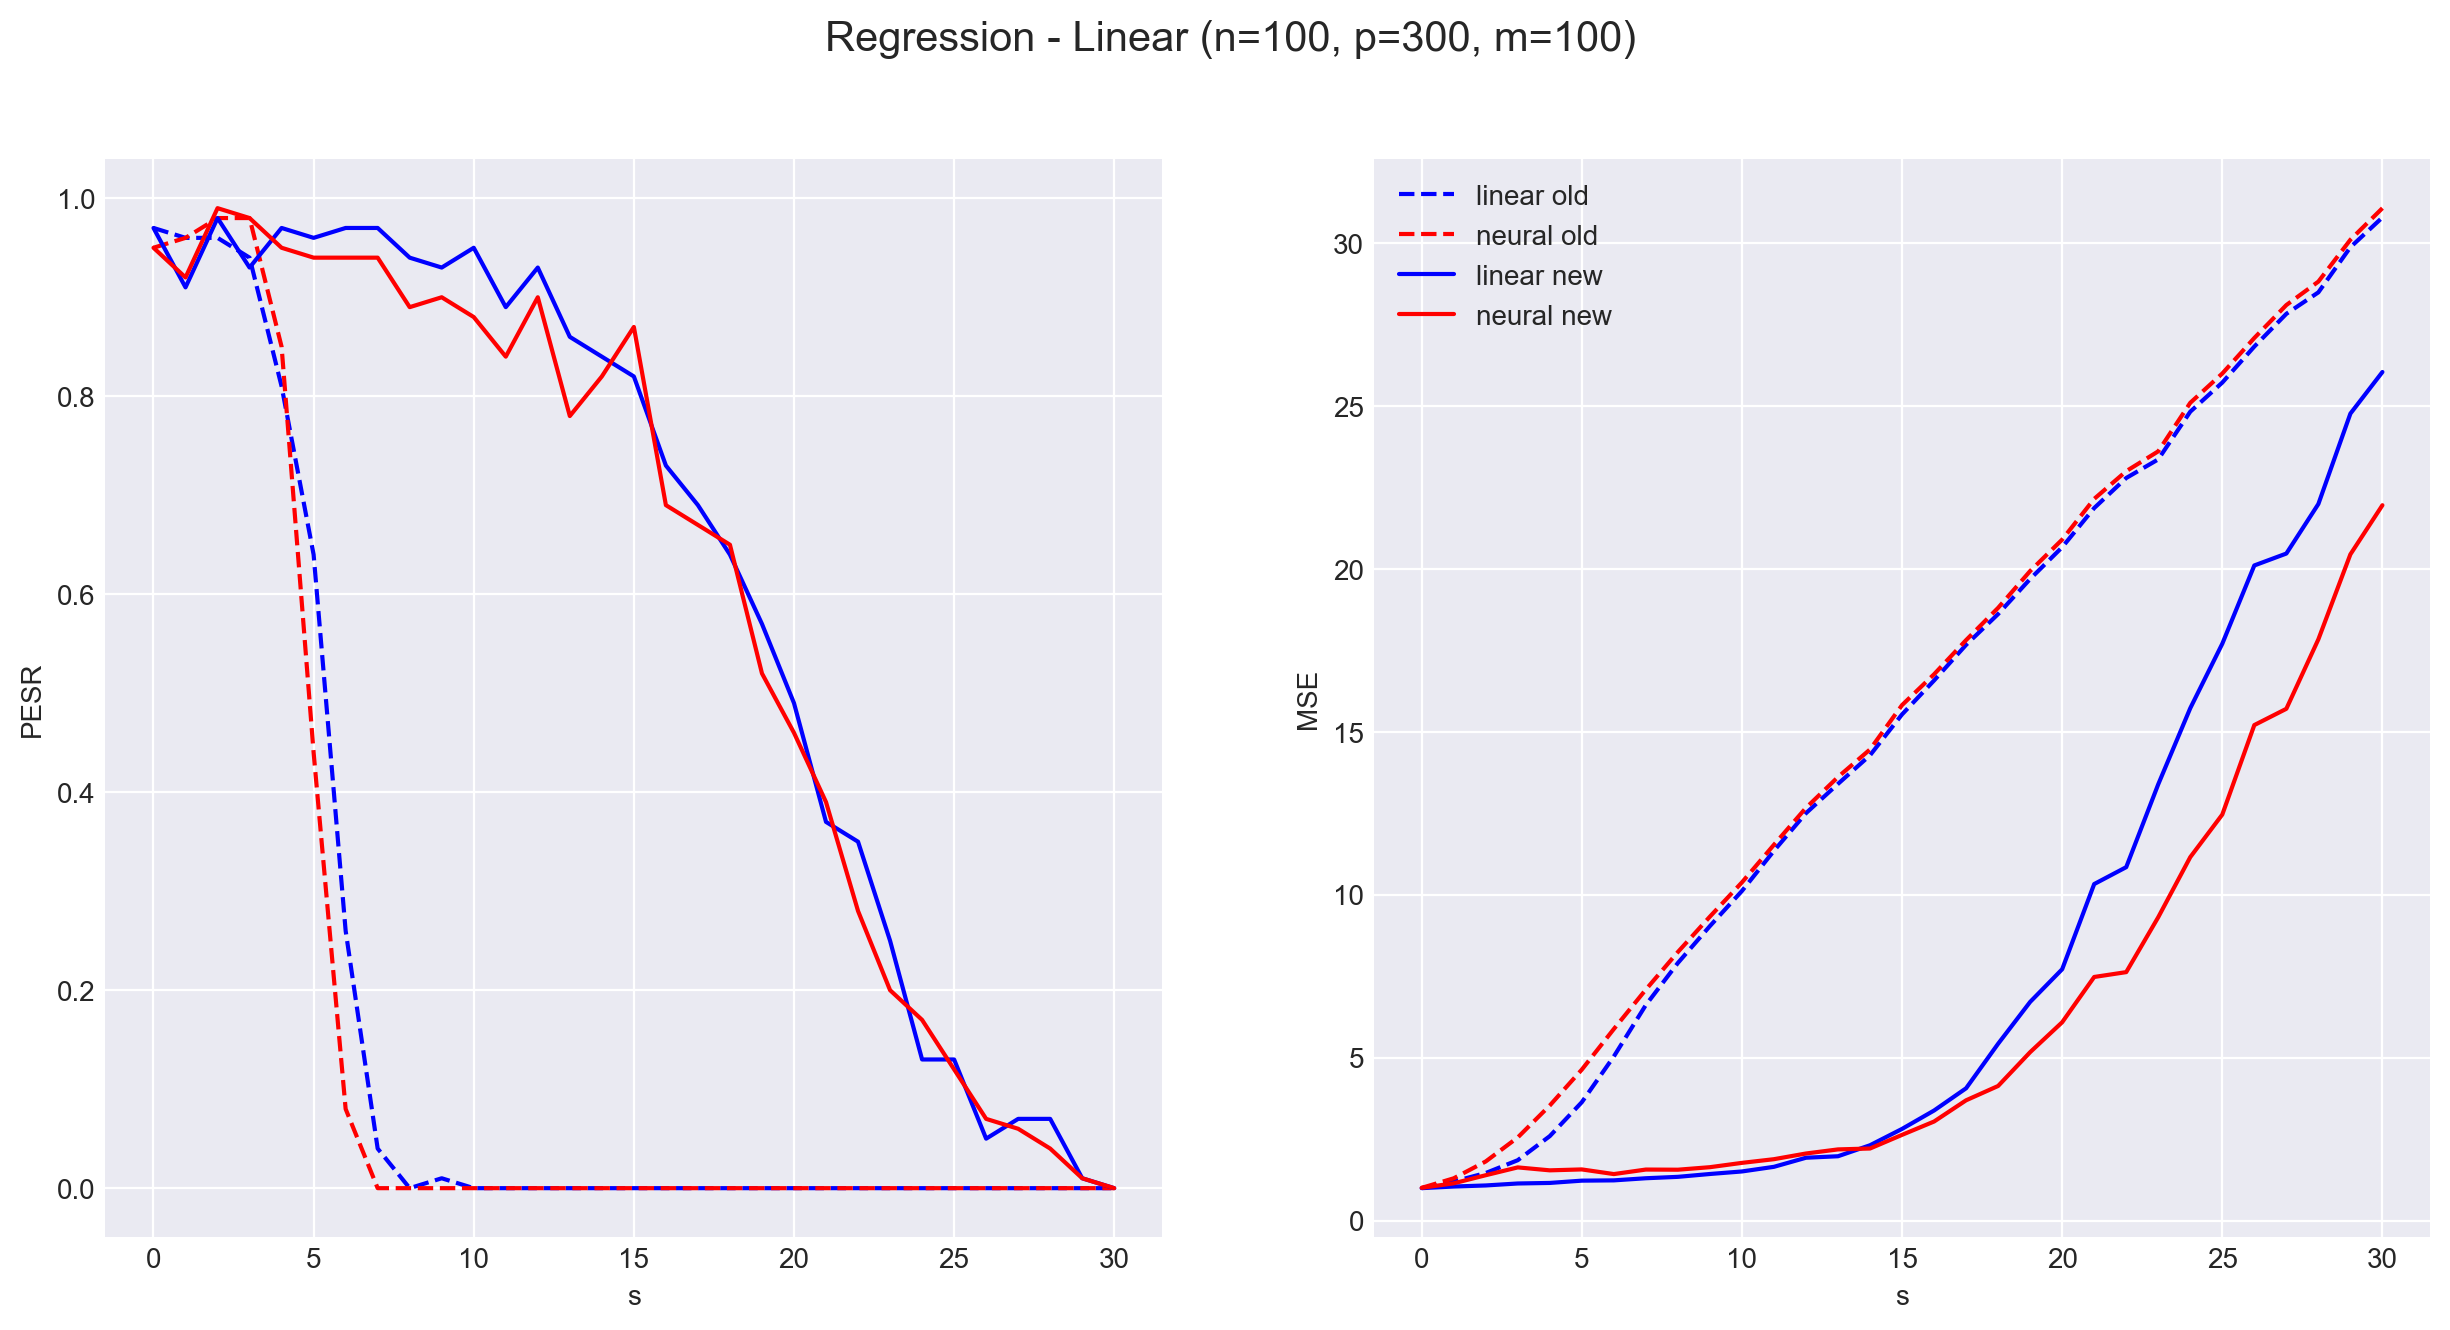

In [18]:
errors = pd.read_csv("data/linear/n100/results/errors.csv")
PESR = pd.read_csv("data/linear/n100/results/PESR.csv")
names = PESR.keys()
styles = ['b--', 'r--', 'b-', 'r-'] # Red for neural, dotted for old penalty

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=200)

for name, style in zip(names, styles):
    ax1.plot(np.arange(31), PESR[name], style)
    ax2.plot(np.arange(31), errors[name], style, label=name)

ax1.set_xlabel("s")
ax1.set_ylabel("PESR")

ax2.set_xlabel("s")
ax2.set_ylabel("MSE")
ax2.legend()

plt.suptitle("Regression - Linear (n=100, p=300, m=100)", fontsize=15)
plt.show()

<h1><center>Regression - Nonlinear data</center></h1>

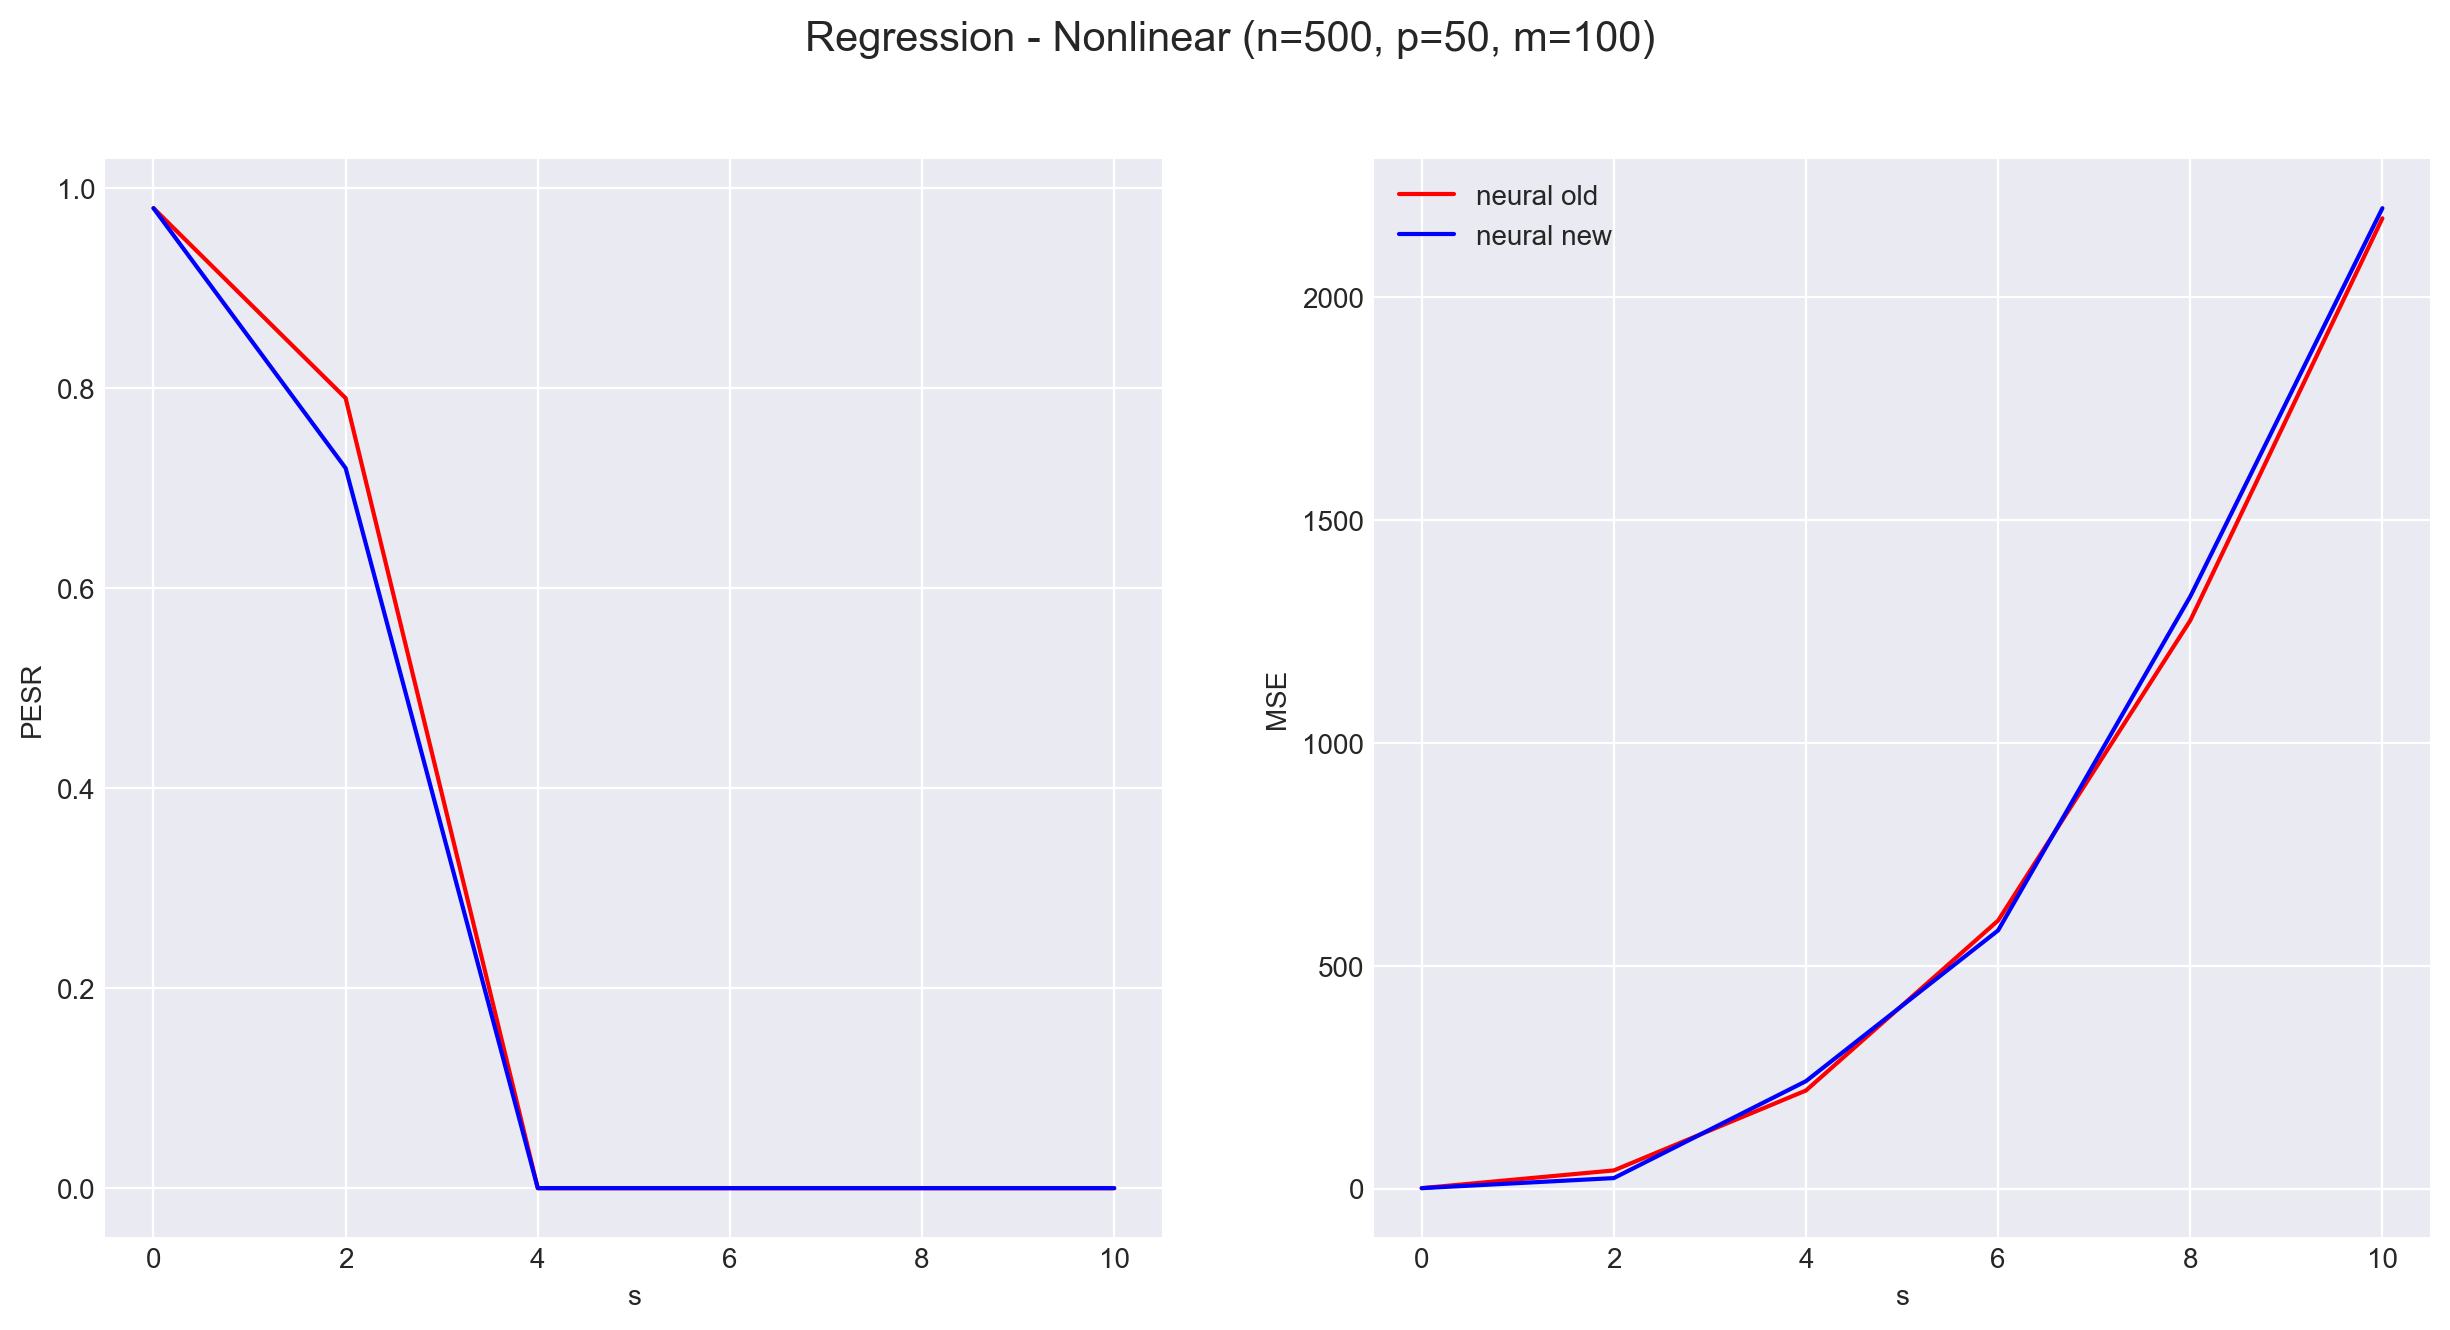

In [19]:
errors = pd.read_csv("data/nonlinear/n500/Results/errors.csv")
PESR = pd.read_csv("data/nonlinear/n500/Results/PESR.csv")
names = PESR.keys()

styles = ['r-', 'b-'] # red for old blue for new

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=200)

for name, style in zip(names, styles):
    ax1.plot(np.arange(0, 12, 2), PESR[name], style)
    ax2.plot(np.arange(0, 12, 2), errors[name], style, label=name)

ax1.set_xlabel("s")
ax1.set_ylabel("PESR")

ax2.set_xlabel("s")
ax2.set_ylabel("MSE")
ax2.legend()

plt.suptitle("Regression - Nonlinear (n=500, p=50, m=100)", fontsize=15)
plt.show()

<h1><center>Classification</center></h1>

In [4]:
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.metrics import accuracy_score
import os
from tqdm import tqdm

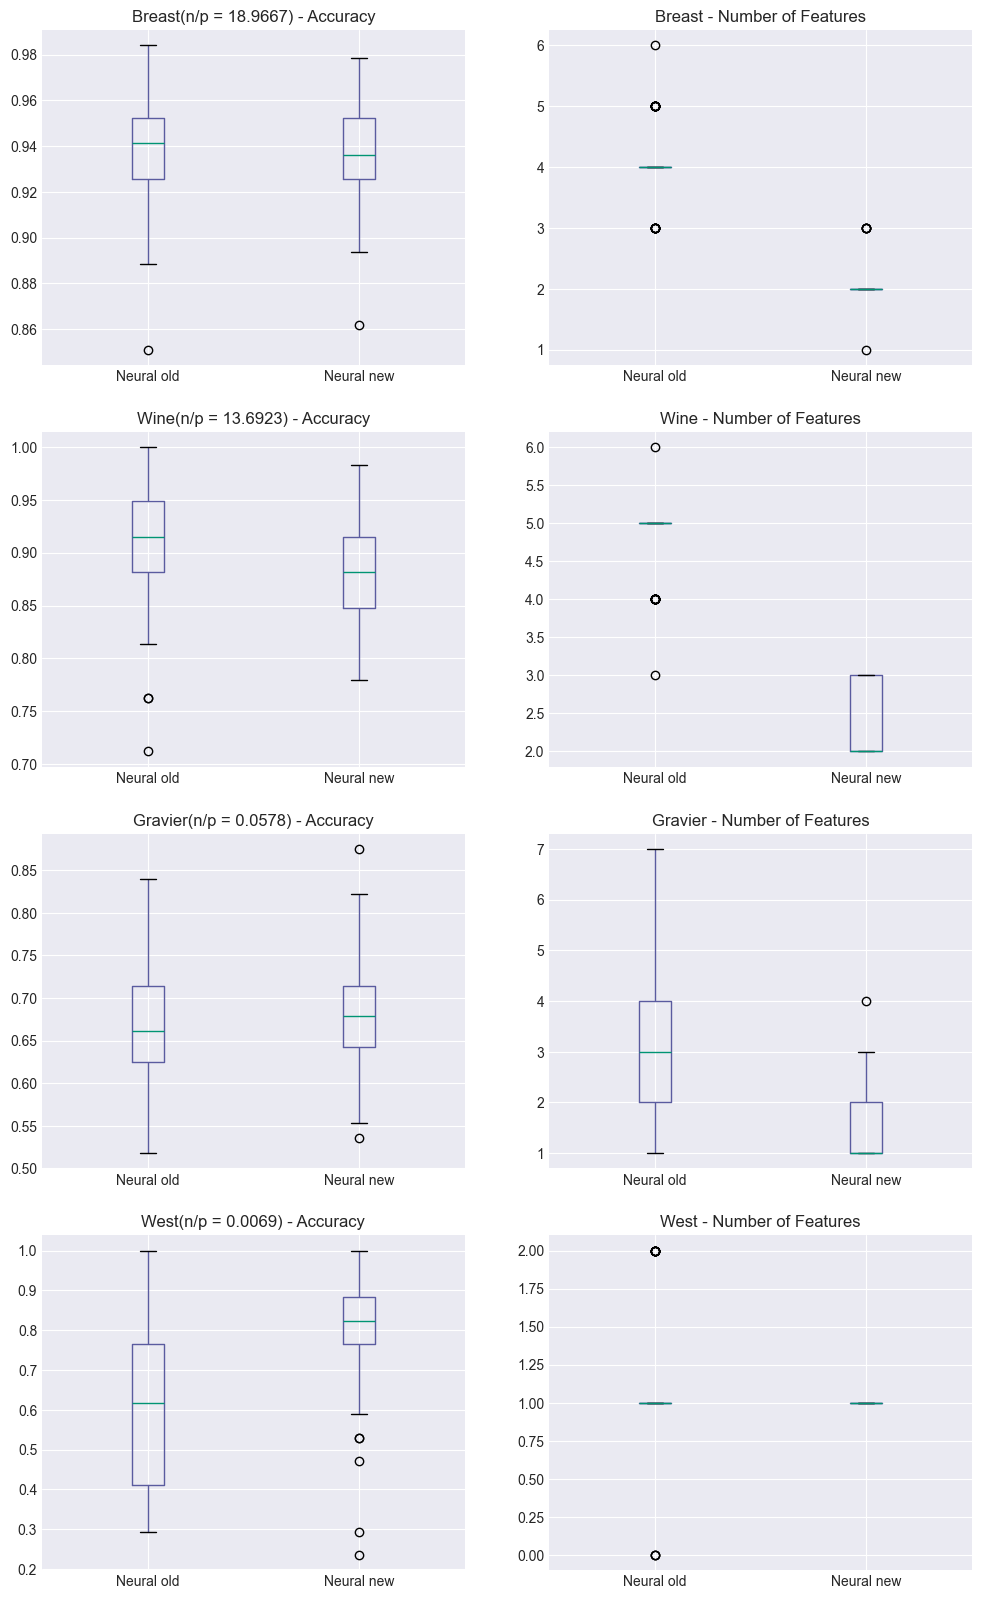

In [20]:
names = ["Breast", "Wine", "Gravier", "West"]
ratio = {"Breast": 18.9667, "Wine": 13.6923, "Gravier": 0.0578, "West": 0.0069}

fig, axs = plt.subplots(4, 2, figsize=(12, 20))


for name, (ax1, ax2) in zip(names, axs):
    accuracies = pd.read_csv(f'data/classification/{name}/Results/accuracies.csv')
    n_features = pd.read_csv(f'data/classification/{name}/Results/selected_features.csv')

    accuracies.boxplot(ax=ax1)
    ax1.set_title(f'{name}(n/p = {ratio[name]}) - Accuracy')

    n_features.boxplot(ax=ax2)
    ax2.set_title(f'{name} - Number of Features')

plt.show()
